In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import os
import torch
import time
import cv2
from ultralytics import YOLO
from collections import deque, defaultdict


# Détection de chute : Computer Vision Projet. 

# **Mathéo STEPHAN & Florian VITOUX** 


## Objectif du projet

L’objectif de ce projet est de détecter automatiquement la chute d’une personne à partir d’images ou de vidéos, à l’aide de techniques de computer vision.
Ce type de système peut être utile dans des contextes comme la surveillance de personnes âgées ou la sécurité.

Deux méthodes ont été utilisées :

* Détection d’objet avec un dataset d'image de "chute".
* Détection de pose avec estimation de la pose est étude de celle-ci

 ### Méthode 1 — Détection d’objet, entrainement sur un dataset

Cette approche consiste à entraîner un détecteur d’objets à reconnaître directement des états liés à la chute.

Idée : si le modèle détecte une personne dans une posture/position “au sol”, on déclenche une alerte.

Avantages

- Simple à déployer : une seule étape d’inférence (un modèle).
- Rapide (temps réel possible).
- Fonctionne bien si le dataset est correctement annoté.

Limites

- Généralise moins bien si les scènes changent (angle caméra, éclairage, vêtements, occlusions).
- Peut confondre “allongé” (pas une chute) et “chute réelle” si la classe n’est pas bien définie.

#### Vérification des fichiers et du GPU

> Voici le lien vers le dataset qui a servi d'entrainement : https://universe.roboflow.com/yolo-r6q9v/fall-brac6/dataset/1


In [3]:
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

DATA_YAML = Path("data.yaml")  

print("data.yaml exists:", DATA_YAML.exists())
print("data.yaml path:", DATA_YAML)

# afficher le contenu du YAML pour vérifier si tout est OK
print("\n--- data.yaml ---")
print(DATA_YAML.read_text(encoding="utf-8"))


Torch: 2.5.1
CUDA available: True
data.yaml exists: True
data.yaml path: data.yaml

--- data.yaml ---
train: dataset/train/images
val: dataset/valid/images
test: dataset/test/images

nc: 1
names: ['fall']

roboflow:
  workspace: yolo-r6q9v
  project: fall-brac6
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/yolo-r6q9v/fall-brac6/dataset/1



In [4]:
cfg = yaml.safe_load(Path(DATA_YAML).read_text(encoding="utf-8"))
print(cfg)

def check_path(p):
    p = Path(p)
    print("OK" if p.exists() else "Erreur", p)

base = Path(cfg.get("path", "."))
print("\nBase:", base.resolve())

for k in ["train", "val", "valid", "test"]:
    if k in cfg:
        check_path(base / cfg[k])


{'train': 'dataset/train/images', 'val': 'dataset/valid/images', 'test': 'dataset/test/images', 'nc': 1, 'names': ['fall'], 'roboflow': {'workspace': 'yolo-r6q9v', 'project': 'fall-brac6', 'version': 1, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/yolo-r6q9v/fall-brac6/dataset/1'}}

Base: C:\Users\FLO\Documents\GitHub\ComputerVision-project-Fall-Detection
OK dataset\train\images
OK dataset\valid\images
OK dataset\test\images


#### Phase de training

(pas besoin de relancer sauf si vous souhaitez améliorer les performances du modèle)

Avec le datset télécharger et les chemins mit à jour, vous pourrez alors lancer un entrainement

In [ ]:
model = YOLO("yolov8n.pt")

# réglages 
EPOCHS = 80      # monte si tu as le temps
BATCH  = 16       # 16 peut être lourd sur CPU mais sur GPU ça passe
IMGSZ  = 640     # baisse si c'est trop lent

print("Training done.")

# Question utilisateur
answer = input("Souhaitez-vous relancer un nouvel entraînement ? (oui / non) : ").lower()

if answer == "oui":
    print("Lancement de l'entrainement")
    
    results = model.train(
        data=str(DATA_YAML),
        epochs=EPOCHS,
        batch=BATCH,
        imgsz=IMGSZ,
        project="dataset/runs/detect",
        name="fall_train1",
        verbose=True
    )

    print("fini")

else:
    print("stop")

Training done.
Lancement de l'entrainement
New https://pypi.org/project/ultralytics/8.3.240 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.238  Python-3.10.18 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, 

On vérifie que le modèle est bien là


In [5]:
runs_dir = Path("dataset/runs/detect")
cands = sorted(runs_dir.glob("fall_train1/weights/best.pt"), key=lambda p: p.stat().st_mtime, reverse=True) # A changer selon votre entrainement

if not cands:
    raise FileNotFoundError(f"Aucun best.pt trouvé dans {runs_dir.resolve()}")

BEST_PT = cands[0].resolve()
print("Best model:", BEST_PT)


Best model: C:\Users\FLO\Documents\GitHub\ComputerVision-project-Fall-Detection\dataset\runs\detect\fall_train1\weights\best.pt


#### Test sur Image
Ce type de méthode marche très bien avec des images, nous avons fait quelques tests

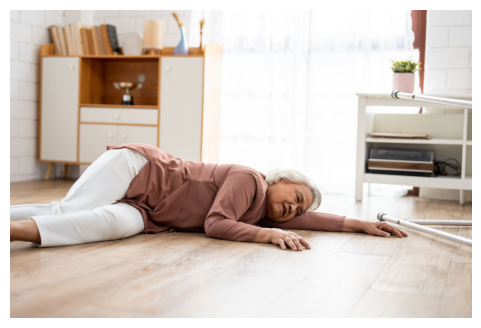

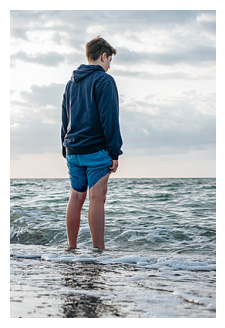

In [6]:
IMG_PATH = Path("img_video/img1.jpg")
IMG_PATH2 = Path("img_video/img2.jpg")

IMGSZ  = 640     # baisse si c'est trop lent
img = cv2.imread(str(IMG_PATH))
img2 = cv2.imread(str(IMG_PATH2))
assert img is not None, "Image non lue"
assert img2 is not None, "Image non lue"

plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()



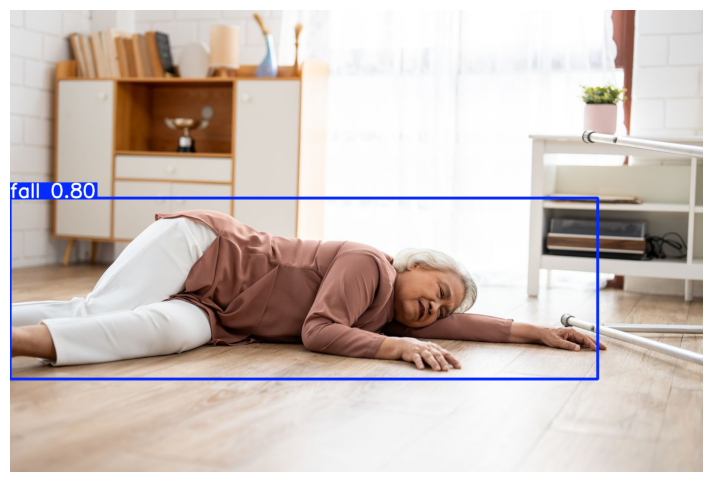

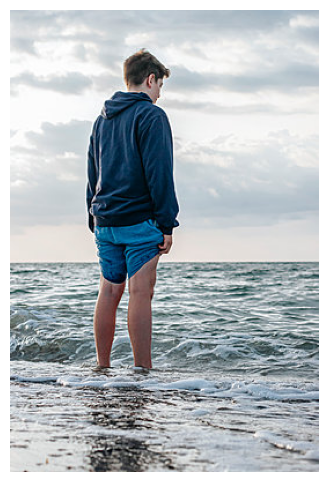

In [7]:
fall_model = YOLO(str(BEST_PT))

img = cv2.imread(str(IMG_PATH))
img2 = cv2.imread(str(IMG_PATH2))
if img is None:
    raise FileNotFoundError(f"Image introuvable: {IMG_PATH}")
if img2 is None:
    raise FileNotFoundError(f"Image introuvable: {IMG_PATH2}")

pred = fall_model(img, imgsz=IMGSZ, conf=0.25, verbose=False)[0]
annot = pred.plot()  # image annotée (bbox + label)

pred2 = fall_model(img2, imgsz=IMGSZ, conf=0.25, verbose=False)[0]
annot2 = pred2.plot()  # image annotée (bbox + label)

annot_rgb = cv2.cvtColor(annot, cv2.COLOR_BGR2RGB)
annot2_rgb = cv2.cvtColor(annot2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,6))
plt.imshow(annot_rgb)
plt.axis("off")
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(annot2_rgb)
plt.axis("off")
plt.show()

#### Test sur Video

Comme pour les images, vous pouvez mettre la vidéo que vous souhaitez pour tester le modèle

In [13]:
VIDEO_PATH = "img_video/chute3.mp4"
# VIDEO_PATH = 0

fall_model = YOLO(str(BEST_PT))
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise FileNotFoundError("Impossible d'ouvrir la vidéo.")

# FPS (fallback)
video_fps = cap.get(cv2.CAP_PROP_FPS)
if not video_fps or video_fps <= 1e-2:
    video_fps = 25.0
frame_dt = 1.0 / video_fps

output_path = "img_video/chute3_detected.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")

out_writer = None

t0 = time.time()
next_t = time.perf_counter()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    pred = fall_model(frame, imgsz=IMGSZ, conf=0.35, verbose=False)[0]
    out = pred.plot()  # frame annoté

    # Init writer au 1er frame (évite width/height = 0 avec GIF)
    if out_writer is None:
        h, w = out.shape[:2]
        out_writer = cv2.VideoWriter(output_path, fourcc, video_fps, (w, h))
        if not out_writer.isOpened():
            cap.release()
            raise RuntimeError("Impossible d'ouvrir le VideoWriter (codec/chemin).")

    out_writer.write(out) 

    cv2.imshow("fall_model test", out)
    if cv2.waitKey(1) & 0xFF in (27, ord("q")):
        break

    next_t += frame_dt
    sleep_s = next_t - time.perf_counter()
    if sleep_s > 0:
        time.sleep(sleep_s)

    if time.time() - t0 > 180:
        break

cap.release()
if out_writer is not None:
    out_writer.release()   
cv2.destroyAllWindows()

print(f"Video saved to: {output_path}")
print("Done.")


Video saved to: img_video/chute3_detected.mp4
Done.


### Méthode 2 : Détection de pose

Cette fois, on vise à détecter une chute sans entraîner de modèle spécifique, en analysant la posture et le mouvement du corps humain à partir d’une vidéo.

Contrairement à une simple détection d’objet, cette méthode se base sur :

* la position des articulations du corps
* leur évolution dans le temps

Avantages :

* Pas besoin d’entraîner un modèle
* Approche explicable (basée sur des règles simples)
* Fonctionne sur des vidéos variées

Complémentaire à une détection par apprentissage

Limites :

* Sensible aux occlusions
* Dépend de la qualité de la pose estimation
* Les règles doivent être ajustées selon la scène





#### Principe général de la détection

La détection de chute repose sur deux états principaux :

* FALLING : la personne est en train de tomber
* FALLEN : la personne est au sol après la chute

#### Deux méthodes sont possibles dans le code (une seule est activée à la fois).

##### Méthode principale — Analyse par frames

On observe l’évolution verticale des articulations sur plusieurs images consécutives.

* Si plusieurs points du corps descendent rapidement vers le bas,
on considère que la personne est en train de tomber.

> Cette méthode est simple et efficace lorsque la vidéo a un FPS correct.

##### Méthode alternative — Analyse temporelle

Lorsque le nombre d’images par seconde est faible, on peut analyser la vitesse verticale des hanches en fonction du temps réel.

* Une vitesse verticale élevée vers le bas indique une chute.


dans tous les cas, une personne est considérée comme au sol quand :

* les hanches restent bas dans l’image (marche bien si le cadre de la vidéo de change pas)
* la position est stable pendant plusieurs frames (peux faire des fausses détection si la personne est juste assise)


> Un critère basé sur la forme de la bounding box est aussi ajouté, cela permet de renforcer la détection lorsque certains points du corps sont mal détectés.

In [20]:
# -----------------------------
# CONFIG
# -----------------------------
USE_VIDEO = True
VIDEO_PATH = "img_video/chute1.mp4"
# ou pour webcam: VIDEO_PATH = 0

# Choix de la méthode
USE_TRACKING = True       # recommandé
USE_TIME_METHOD = False    # recommandé si FPS faible
DEBUG = False

# Pose
CONF_THRESH = 0.5
NOSE = 0
L_SHOULDER, R_SHOULDER = 5, 6
L_HIP, R_HIP = 11, 12
CARDINAL_POINTS = [NOSE, L_SHOULDER, R_SHOULDER, L_HIP, R_HIP]

# Historiques
HISTORY_LEN = 30

# FALLING (frames)
DROP_FRAMES = 5
DROP_THRESH = 0.12

# FALLING (time)
LOOKBACK_SEC = 0.6
VY_THRESH = 0.35

# ON_GROUND (hips)
LOW_Y_THRESH = 0.75
GROUND_FRAMES = 10
GROUND_STABLE_TOL = 0.03

# ON_GROUND (bbox)
ASPECT_RATIO_THRESH = 1.3

WINDOW = "Fall detection"
IMG_SIZE = 640

# -----------------------------
# INIT
# -----------------------------
model = YOLO("yolov8n-pose.pt")

source = VIDEO_PATH if USE_VIDEO else 0
cap = cv2.VideoCapture(source)
if not cap.isOpened():
    print("Erreur : impossible d'ouvrir :", source)
    raise SystemExit(1)

cv2.namedWindow(WINDOW)
running = True
quit_rect = None  # (x, y, w, h)

joint_history_by_id = defaultdict(lambda: {idx: deque(maxlen=HISTORY_LEN) for idx in CARDINAL_POINTS})
hip_history_by_id = defaultdict(lambda: deque(maxlen=HISTORY_LEN))  # time: (t,y) / frames: y

# -----------------------------
# HELPERS
# -----------------------------
def mean_hips_y(kpts_xyn, kpts_conf):
    ys = []
    for idx in (L_HIP, R_HIP):
        if idx < len(kpts_xyn) and kpts_conf[idx] > CONF_THRESH:
            ys.append(float(kpts_xyn[idx][1]))
    return (sum(ys) / len(ys)) if ys else None

def falling_frames(joint_history):
    for idx, hist in joint_history.items():
        if len(hist) < DROP_FRAMES + 1:
            continue
        dy = hist[-1] - hist[-DROP_FRAMES - 1]
        if dy > DROP_THRESH:
            if DEBUG:
                print(f"[FALL/frames] idx={idx} dy={dy:.3f}")
            return True
    return False

def falling_time(hip_hist):
    if len(hip_hist) < 2:
        return False

    t2, y2 = hip_hist[-1]
    target_t = t2 - LOOKBACK_SEC

    t1, y1 = hip_hist[0]
    for (tt, yy) in reversed(hip_hist):
        if tt <= target_t:
            t1, y1 = tt, yy
            break

    dt = max(1e-3, t2 - t1)
    vy = (y2 - y1) / dt

    if DEBUG:
        print(f"[FALL/time] dt={dt:.3f} vy={vy:.3f}")

    return vy > VY_THRESH

def on_ground_from_hips(hip_y_hist):
    if len(hip_y_hist) < GROUND_FRAMES:
        return False
    recent = list(hip_y_hist)[-GROUND_FRAMES:]
    mean_y = sum(recent) / len(recent)
    span = max(recent) - min(recent)
    return (mean_y > LOW_Y_THRESH) and (span < GROUND_STABLE_TOL)

def mouse_callback(event, x, y, flags, param):
    global running, quit_rect
    if event == cv2.EVENT_LBUTTONDOWN and quit_rect is not None:
        rx, ry, rw, rh = quit_rect
        if rx <= x <= rx + rw and ry <= y <= ry + rh:
            running = False

cv2.setMouseCallback(WINDOW, mouse_callback)

# -----------------------------
# LOOP
# -----------------------------
while running:
    ret, frame = cap.read()
    if not ret:
        break

    h, w = frame.shape[:2]

    # define QUIT button once
    if quit_rect is None:
        btn_w, btn_h = 110, 40
        quit_rect = (w - btn_w - 10, h - btn_h - 10, btn_w, btn_h)

    # inference
    if USE_TRACKING:
        res = model.track(frame, imgsz=IMG_SIZE, persist=True, verbose=False)[0]
    else:
        res = model(frame, imgsz=IMG_SIZE, verbose=False)[0]
    
    annotated = res.plot()  # garde bbox + squelette


    falling_any = False
    ground_any = False
    person_detected = False

    if res.boxes is not None and len(res.boxes) > 0:
        person_detected = True
        boxes = res.boxes
        kps = res.keypoints

        # ids
        if USE_TRACKING and boxes.id is not None:
            tids = boxes.id.cpu().numpy().astype(int).tolist()
            indices = list(range(len(boxes)))
        else:
            best_idx = boxes.conf.argmax().item()
            tids = [0]
            indices = [best_idx]

        now = time.time()

        for det_i, tid in zip(indices, tids):
            box = boxes[det_i]
            kpt = kps[det_i]

            kpts_xyn = kpt.xyn.cpu().numpy()
            kpts_conf = kpt.conf.cpu().numpy()

            if kpts_xyn.ndim == 3:  # safety
                kpts_xyn = kpts_xyn[0]
            if kpts_conf.ndim == 2:
                kpts_conf = kpts_conf[0]

            joint_hist = joint_history_by_id[tid]
            hip_hist = hip_history_by_id[tid]

            # update joint histories (optional for frames method)
            if not USE_TIME_METHOD:
                for idx in CARDINAL_POINTS:
                    if idx < len(kpts_xyn) and kpts_conf[idx] > CONF_THRESH:
                        joint_hist[idx].append(float(kpts_xyn[idx][1]))

            # update hip mean history
            hipy = mean_hips_y(kpts_xyn, kpts_conf)
            if hipy is not None:
                if USE_TIME_METHOD:
                    hip_hist.append((now, hipy))
                else:
                    hip_hist.append(hipy)

            # bbox aspect ratio (fallback)
            xyxy = box.xyxy.cpu().numpy()[0]
            bw = xyxy[2] - xyxy[0]
            bh = xyxy[3] - xyxy[1]
            aspect_fallen = (bh > 10) and ((bw / bh) > ASPECT_RATIO_THRESH)

            # FALLING
            if USE_TIME_METHOD:
                fall = falling_time(hip_hist) if len(hip_hist) and isinstance(hip_hist[0], tuple) else False
            else:
                fall = falling_frames(joint_hist)

            # ON_GROUND from hips (+ aspect as fallback)
            if USE_TIME_METHOD:
                hip_y_only = [yy for (_, yy) in hip_hist]
            else:
                hip_y_only = list(hip_hist)

            ground = on_ground_from_hips(hip_y_only) or aspect_fallen

            falling_any |= fall
            ground_any |= ground

    else:
        # no person -> clear histories (avoids stale triggers)
        joint_history_by_id.clear()
        hip_history_by_id.clear()

    # minimal display (state + quit button)
    if not person_detected:
        txt, color = "NO PERSON", (200, 200, 200)
    elif ground_any:
        txt, color = "FALLEN", (0, 0, 255)
    elif falling_any:
        txt, color = "FALLING", (0, 165, 255)
    else:
        txt, color = "SAFE", (0, 255, 0)


    cv2.putText(annotated, txt, (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.6, color, 4)

    # QUIT button
    qx, qy, qw, qh = quit_rect
    cv2.rectangle(annotated, (qx, qy), (qx + qw, qy + qh), (0, 0, 255), -1)
    cv2.putText(annotated, "QUIT", (qx + 20, qy + 28),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    cv2.imshow(WINDOW, annotated)

    key = cv2.waitKey(1) & 0xFF
    if key in (27, ord("q")):
        running = False

cap.release()
cv2.destroyAllWindows()


#### Pourquoi YOLOv8 Pose ?

Il détecte à la fois :

* la personne (bounding box)
* le squelette du corps (points clés)
* Il est rapide et compatible avec le temps réel
* Il ne nécessite pas d’entraînement supplémentaire

Le modèle fournit pour chaque personne :

* une boîte englobante
* les coordonnées des principales articulations (épaules, hanches, tête, etc.)



Pour simplifier l’analyse, seuls quelques points clés sont utilisés :

tête (nez),
épaules,
hanches

Ces points sont suffisants pour estimer :

l’orientation du corps et 
la position par rapport au sol

## Test mix des deux méthodes

Pour finir, nous avons chercher à mixer les deux méthodes afin d'essayer d'encore plus améliorer la précision.

Ceci n'est cependant qu'une première idée, non fini par manque de temps

In [21]:
# -----------------------------
# CONFIG
# -----------------------------
USE_VIDEO = True
VIDEO_PATH = "img_video/chute1.mp4" # ou pour webcam: VIDEO_PATH = 0

USE_TRACKING = True
USE_TIME_METHOD = False
DEBUG = False

# === modèle entraîné (detect) ===
USE_FALL_MODEL = True
FALL_MODEL_PATH = "dataset/runs/detect/fall_train1/weights/best.pt"  # <-- ton best.pt
FALL_CONF_THRESH = 0.50
FALL_CLASS_ID = 0
FALL_CONFIRM_FRAMES = 2

# Pose (pour FALLING)
CONF_THRESH = 0.5
NOSE = 0
L_SHOULDER, R_SHOULDER = 5, 6
L_HIP, R_HIP = 11, 12
CARDINAL_POINTS = [NOSE, L_SHOULDER, R_SHOULDER, L_HIP, R_HIP]

HISTORY_LEN = 30
DROP_FRAMES = 5
DROP_THRESH = 0.12

LOOKBACK_SEC = 0.6
VY_THRESH = 0.35

LOW_Y_THRESH = 0.75
GROUND_FRAMES = 10
GROUND_STABLE_TOL = 0.03

ASPECT_RATIO_THRESH = 1.3

WINDOW = "Fall detection"
IMG_SIZE = 640

# -----------------------------
# INIT
# -----------------------------
pose_model = YOLO("yolov8n-pose.pt")

# sécurité si best.pt pas encore là
if USE_FALL_MODEL and not os.path.exists(FALL_MODEL_PATH):
    print("⚠️ best.pt introuvable, désactivation du fall_model:", FALL_MODEL_PATH)
    USE_FALL_MODEL = False

fall_model = YOLO(FALL_MODEL_PATH) if USE_FALL_MODEL else None
fall_hit_streak = 0

source = VIDEO_PATH if USE_VIDEO else 0
cap = cv2.VideoCapture(source)
if not cap.isOpened():
    print("Erreur : impossible d'ouvrir :", source)
    raise SystemExit(1)

cv2.namedWindow(WINDOW)
running = True
quit_rect = None

joint_history_by_id = defaultdict(lambda: {idx: deque(maxlen=HISTORY_LEN) for idx in CARDINAL_POINTS})
hip_history_by_id = defaultdict(lambda: deque(maxlen=HISTORY_LEN))

# -----------------------------
# HELPERS
# -----------------------------
def mean_hips_y(kpts_xyn, kpts_conf):
    ys = []
    for idx in (L_HIP, R_HIP):
        if idx < len(kpts_xyn) and kpts_conf[idx] > CONF_THRESH:
            ys.append(float(kpts_xyn[idx][1]))
    return (sum(ys) / len(ys)) if ys else None

def falling_frames(joint_history):
    for idx, hist in joint_history.items():
        if len(hist) < DROP_FRAMES + 1:
            continue
        dy = hist[-1] - hist[-DROP_FRAMES - 1]
        return dy > DROP_THRESH
    return False

def falling_time(hip_hist):
    if len(hip_hist) < 2:
        return False
    t2, y2 = hip_hist[-1]
    target_t = t2 - LOOKBACK_SEC
    t1, y1 = hip_hist[0]
    for (tt, yy) in reversed(hip_hist):
        if tt <= target_t:
            t1, y1 = tt, yy
            break
    dt = max(1e-3, t2 - t1)
    vy = (y2 - y1) / dt
    return vy > VY_THRESH

def on_ground_from_hips(hip_y_hist):
    if len(hip_y_hist) < GROUND_FRAMES:
        return False
    recent = list(hip_y_hist)[-GROUND_FRAMES:]
    mean_y = sum(recent) / len(recent)
    span = max(recent) - min(recent)
    return (mean_y > LOW_Y_THRESH) and (span < GROUND_STABLE_TOL)

def detect_fallen_with_model(frame):
    if fall_model is None:
        return False
    out = fall_model(frame, imgsz=IMG_SIZE, conf=FALL_CONF_THRESH, verbose=False)[0]
    if out.boxes is None or len(out.boxes) == 0:
        return False
    clss = out.boxes.cls.cpu().numpy().astype(int)
    return (clss == FALL_CLASS_ID).any()

def mouse_callback(event, x, y, flags, param):
    global running, quit_rect
    if event == cv2.EVENT_LBUTTONDOWN and quit_rect is not None:
        rx, ry, rw, rh = quit_rect
        if rx <= x <= rx + rw and ry <= y <= ry + rh:
            running = False

cv2.setMouseCallback(WINDOW, mouse_callback)

# -----------------------------
# LOOP
# -----------------------------
while running:
    ret, frame = cap.read()
    if not ret:
        break

    h, w = frame.shape[:2]
    if quit_rect is None:
        quit_rect = (w - 120, h - 60, 110, 40)

    # 1) FALLEN via best.pt (+ confirmation)
    fallen_raw = detect_fallen_with_model(frame) if USE_FALL_MODEL else False
    fall_hit_streak = fall_hit_streak + 1 if fallen_raw else 0
    fallen_confirmed = fall_hit_streak >= FALL_CONFIRM_FRAMES

    # 2) Pose pour FALLING
    if USE_TRACKING:
        res = pose_model.track(frame, imgsz=IMG_SIZE, persist=True, verbose=False)[0]
    else:
        res = pose_model(frame, imgsz=IMG_SIZE, verbose=False)[0]

    annotated = res.plot()

    falling_any = False
    ground_any = False
    person_detected = (res.boxes is not None and len(res.boxes) > 0)

    if person_detected and res.keypoints is not None:
        boxes = res.boxes
        kps = res.keypoints

        if USE_TRACKING and boxes.id is not None:
            tids = boxes.id.cpu().numpy().astype(int).tolist()
            indices = list(range(len(boxes)))
        else:
            best_idx = boxes.conf.argmax().item()
            tids = [0]
            indices = [best_idx]

        now = time.time()

        for det_i, tid in zip(indices, tids):
            box = boxes[det_i]
            kpt = kps[det_i]

            kpts_xyn = kpt.xyn.cpu().numpy()
            kpts_conf = kpt.conf.cpu().numpy()
            if kpts_xyn.ndim == 3:
                kpts_xyn = kpts_xyn[0]
            if kpts_conf.ndim == 2:
                kpts_conf = kpts_conf[0]

            joint_hist = joint_history_by_id[tid]
            hip_hist = hip_history_by_id[tid]

            if not USE_TIME_METHOD:
                for idx in CARDINAL_POINTS:
                    if idx < len(kpts_xyn) and kpts_conf[idx] > CONF_THRESH:
                        joint_hist[idx].append(float(kpts_xyn[idx][1]))

            hipy = mean_hips_y(kpts_xyn, kpts_conf)
            if hipy is not None:
                hip_hist.append((now, hipy) if USE_TIME_METHOD else hipy)

            xyxy = box.xyxy.cpu().numpy()[0]
            bw = xyxy[2] - xyxy[0]
            bh = xyxy[3] - xyxy[1]
            aspect_fallen = (bh > 10) and ((bw / bh) > ASPECT_RATIO_THRESH)

            fall = falling_time(hip_hist) if USE_TIME_METHOD else falling_frames(joint_hist)

            hip_y_only = [yy for (_, yy) in hip_hist] if (USE_TIME_METHOD and hip_hist and isinstance(hip_hist[0], tuple)) else list(hip_hist)
            ground_pose = on_ground_from_hips(hip_y_only) or aspect_fallen

            falling_any |= fall
            ground_any |= ground_pose

    else:
        joint_history_by_id.clear()
        hip_history_by_id.clear()

    # priorité au modèle dataset
    if fallen_confirmed:
        ground_any = True

    # état affiché
    if not person_detected and not fallen_confirmed:
        txt, color = "NO PERSON", (200, 200, 200)
    elif ground_any:
        txt, color = "FALLEN", (0, 0, 255)
    elif falling_any:
        txt, color = "FALLING", (0, 165, 255)
    else:
        txt, color = "SAFE", (0, 255, 0)

    cv2.putText(annotated, txt, (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.6, color, 4)

    qx, qy, qw, qh = quit_rect
    cv2.rectangle(annotated, (qx, qy), (qx + qw, qy + qh), (0, 0, 255), -1)
    cv2.putText(annotated, "QUIT", (qx + 20, qy + 28), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    cv2.imshow(WINDOW, annotated)
    if (cv2.waitKey(1) & 0xFF) in (27, ord("q")):
        break

cap.release()
cv2.destroyAllWindows()
